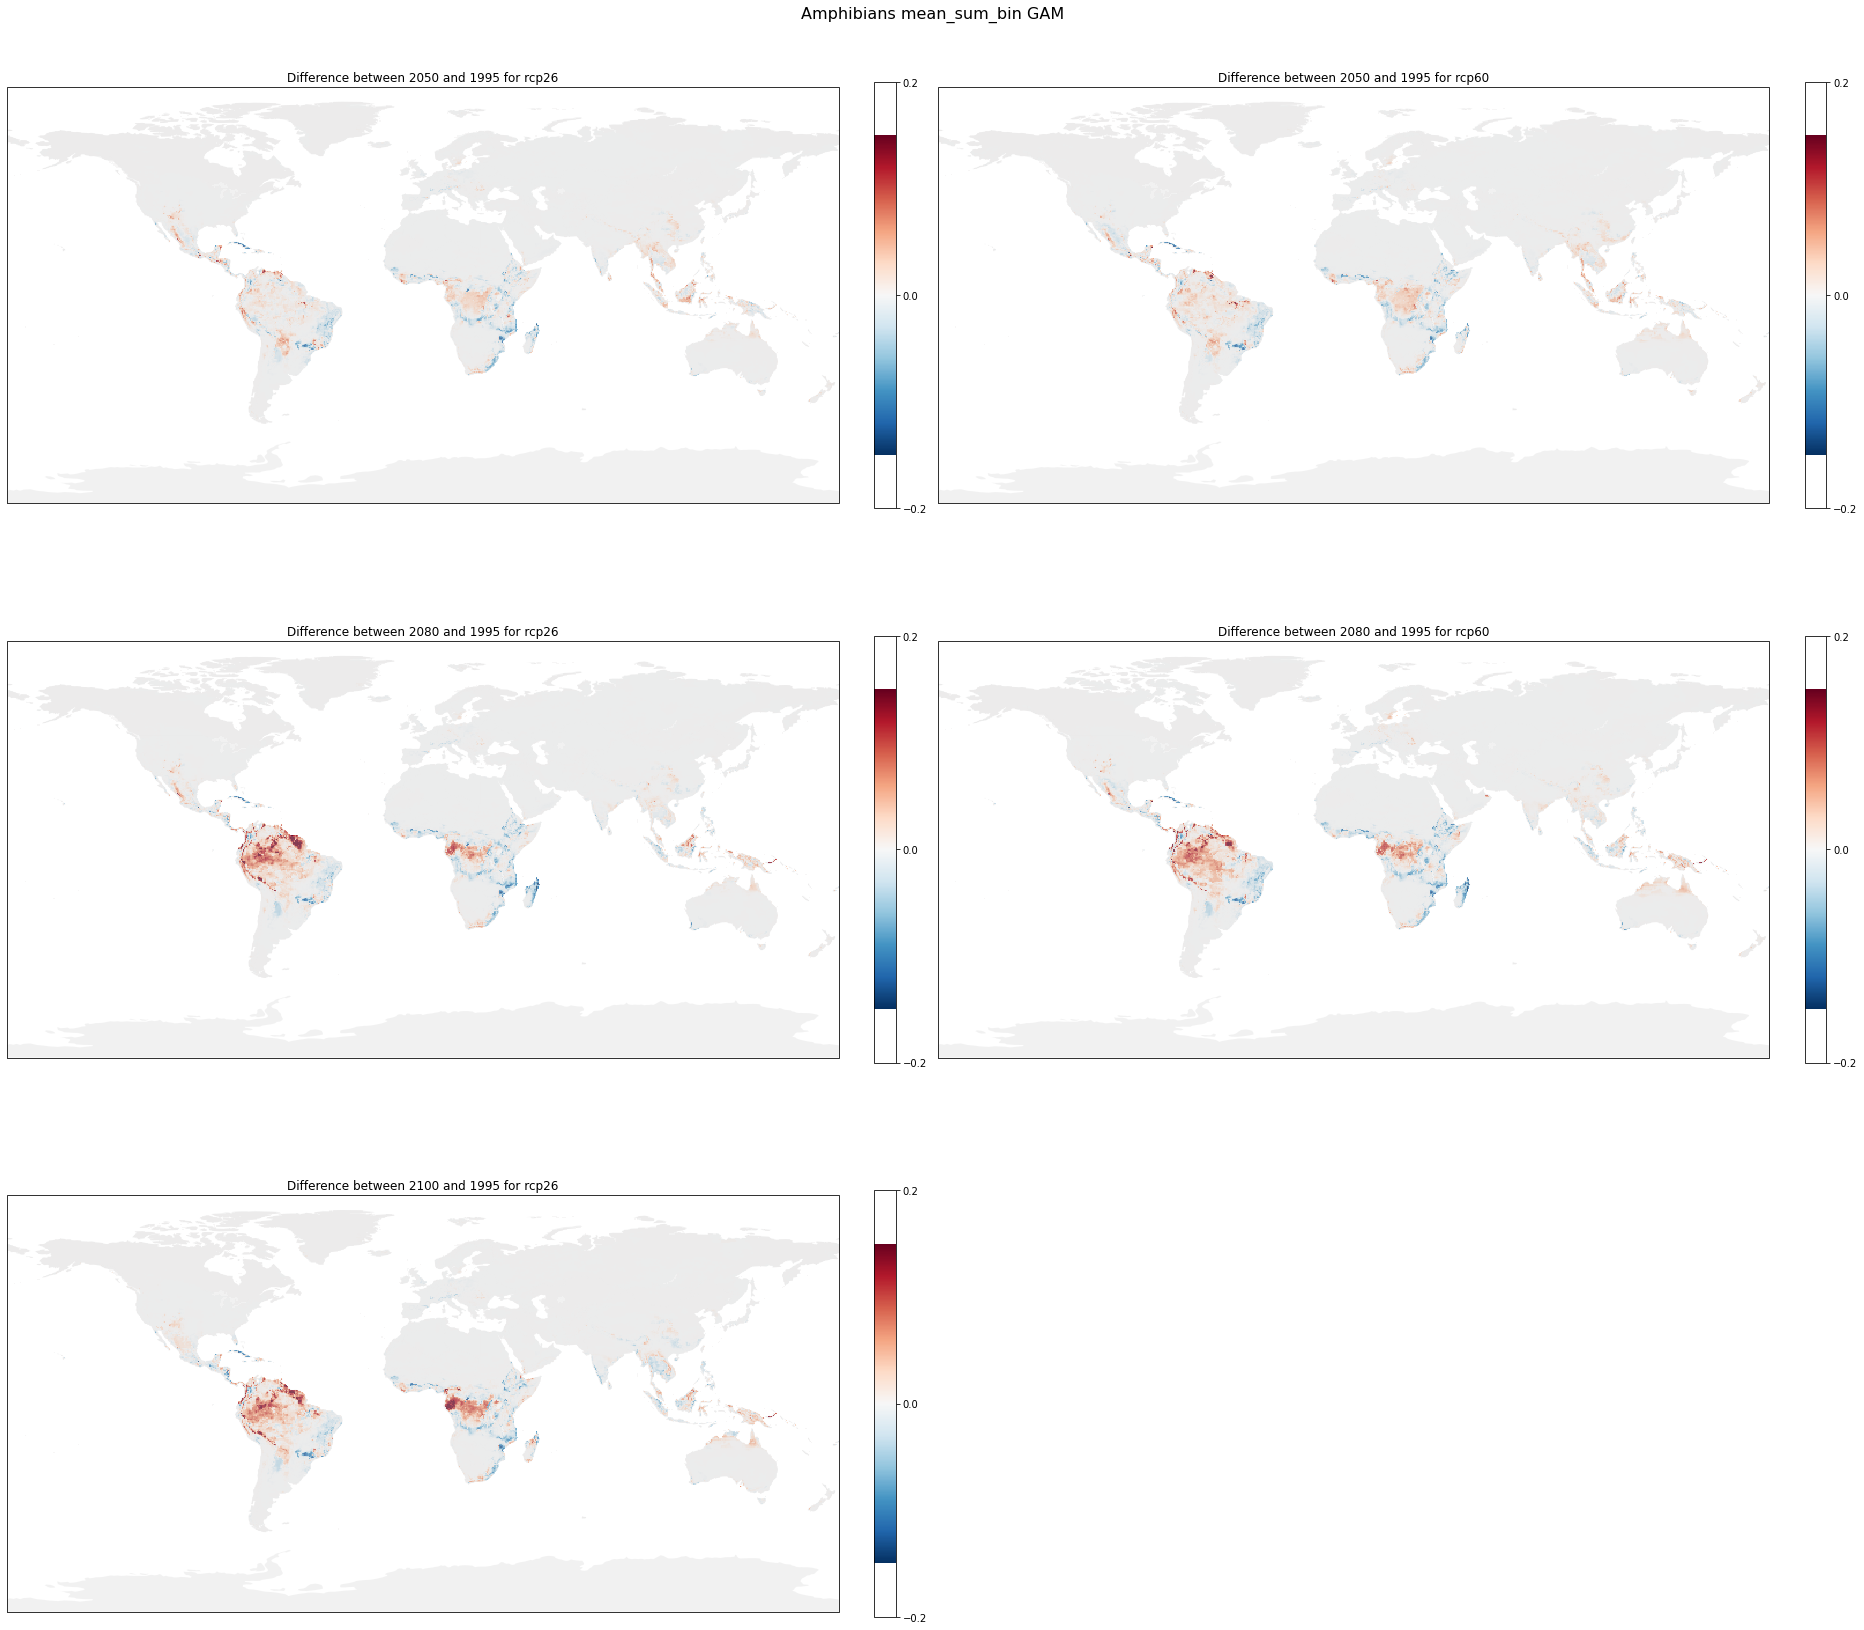

In [13]:
#!/usr/bin/env python3
#pip install  rioxarray==0.3.1
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray
import numpy as np
import geopandas as gpd
import cartopy.crs as ccrs
import rasterio
import os
import matplotlib.colors
scriptsdir = os.getcwd()
from scipy.interpolate import griddata
from functools import reduce
import xarray
import itertools

model="GAM" 
model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

years= ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050', 
                 '2052', '2056', '2080', '2100', '2150', '2200', '2250']


taxas =["Amphibians"]
dir_species = "/storage/scratch/users/ch21o450/data/LandClim_Output/GAM/Amphibians/EWEMBI/"
available_file = os.listdir(dir_species)
available_names = [x.split("_[1146].nc")[0] for x in available_file]


species_names = available_names[:50]

#sum_bin 

def calculate_mean(time, model, netcdf_path_format, is_historical=False, scenario=None):
    newvalue_dict = {model_name: {} for model_name in model_names}
    sum_bin_dict = {model_name: {} for model_name in model_names}

    for model_name in model_names:
        for species_name in species_names:
            if is_historical:
                ds = xr.open_dataset(netcdf_path_format.format(model, species_name, time), decode_times=False)
            else:
                ds = xr.open_dataset(netcdf_path_format.format(model, model_name, scenario, species_name, time), decode_times=False)
            sum_bin = ds["sum_bin"]
            sum_bin_dict[model_name][species_name] = sum_bin

    projections_dict = {}


    for species_name in species_names:
        sum_bin_list = []
        for model_name in model_names:
            sum_bin = sum_bin_dict[model_name][species_name]
            sum_bin_list.append(sum_bin)
        sum_bin_concat = xr.concat(sum_bin_list, dim="model")
        mean_sum_bin = sum_bin_concat.mean(dim="model")
        projections_dict[species_name] = mean_sum_bin

    mean_sum_bin_list = list(projections_dict.values())
    mean_sum_bin = xr.concat(mean_sum_bin_list, dim="species").mean(dim="species")

    return mean_sum_bin

#sum_bin
historical_time = 1146
future_times = [35, 65, 85]


netcdf_path_format_future = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/Amphibians/{}/{}/{}_[{}].nc"
netcdf_path_format_hist = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/Amphibians/EWEMBI/{}_[{}].nc"

mean_hist = calculate_mean(historical_time, model, netcdf_path_format_hist, is_historical=True)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(26, 24), subplot_kw={'projection': ccrs.PlateCarree()})

cmap = matplotlib.colors.ListedColormap(['white', 'green'])
countries = gpd.read_file(
              gpd.datasets.get_path("naturalearth_lowres"))

plot_idx = 0
year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}
for future_time in future_times:
    if future_time == 35 or future_time == 65:
        model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
        scenarios = ["rcp26", "rcp60"]
    elif future_time == 85:
        model_names = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
        scenarios = ["rcp26"]

    for scenario in scenarios:
        if future_time == 85 and scenario == "rcp60":
            continue
            
        mean_future = calculate_mean(future_time, model, netcdf_path_format_future, is_historical=False, scenario=scenario)

        # Select the 0th time slice in mean_future and mean_hist data arrays
        mean_future_slice = mean_future.isel(time=0)
        mean_hist_slice = mean_hist.isel(time=0)

        difference = mean_future_slice - mean_hist_slice
        ax = axes.flatten()[plot_idx]
        im = difference.plot(ax=ax, transform=ccrs.PlateCarree(), cmap="RdBu_r", add_colorbar=False, vmin=-0.15, vmax=0.15)

        countries.plot(ax=ax, color="lightgray", zorder=1, alpha=0.3)
        ax.set_title(f"Difference between {year_indices[future_time]} and {year_indices[historical_time]} for {scenario}")

        cbar = plt.colorbar(im, ax=ax, fraction=0.024, pad=0.04)
        cbar.set_ticks([-0.2, 0, 0.2])

        plot_idx += 1

# Hide the last (empty) subplot
axes.flatten()[-1].set_visible(False)
plt.suptitle('Amphibians mean_sum_bin GAM', size=16)

plt.tight_layout()
plt.show()

#fig.savefig("/storage/homefs/ch21o450/figures/amphibians_gam")


TypeError: unsupported format string passed to numpy.ndarray.__format__

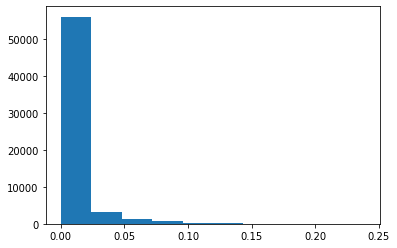

In [12]:
xr.plot.hist(x)

In [14]:
# assume mean_hist is a DataArray containing the mean values of a histogram
# with bin centers along the x-axis

# create an array of values for the x-axis
x = mean_hist.coords['x']

# calculate the probability density function (PDF) using numpy's histogram function
pdf, _ = np.histogram(mean_hist, bins=x, density=True)

# create an xarray DataArray from the PDF array
pdf_da = xr.DataArray(pdf, coords=[('x', x)])

# plot the probability distribution function using matplotlib
pdf_da.plot()


KeyError: 'x'